# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        fold=5,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../logs/comick/79_contexts/10-11-2022_19-39-04/oov_embedding_dict.pkl", "rb"))
oov_embeddings = {key: embeddings["<UNK>"] for key, _ in oov_embeddings.items()}

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/unk/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/unk/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../logs/unk/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../logs/unk/fold_{hyperparams.fold}/{path_name}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5139 | MulticlassF1Score=0.0701
Batch-30 : CrossEntropyLoss=2.4679 | MulticlassF1Score=0.1501
Batch-45 : CrossEntropyLoss=2.5018 | MulticlassF1Score=0.1783
Batch-60 : CrossEntropyLoss=2.4886 | MulticlassF1Score=0.1908
Batch-75 : CrossEntropyLoss=2.4653 | MulticlassF1Score=0.2002
Batch-90 : CrossEntropyLoss=2.4915 | MulticlassF1Score=0.2052
Batch-105: CrossEntropyLoss=2.4868 | MulticlassF1Score=0.2111
Batch-120: CrossEntropyLoss=2.4903 | MulticlassF1Score=0.2150
Batch-135: CrossEntropyLoss=2.4421 | MulticlassF1Score=0.2233
Batch-150: CrossEntropyLoss=2.4781 | MulticlassF1Score=0.2342
Batch-165: CrossEntropyLoss=2.4516 | MulticlassF1Score=0.2443
Batch-180: CrossEntropyLoss=2.4728 | MulticlassF1Score=0.2536
Batch-195: CrossEntropyLoss=2.4511 | MulticlassF1Score=0.2628
Batch-210: CrossEntropyLoss=2.4198 | MulticlassF1Score=0.2760
Batch-225: CrossEntropyLoss=2.3992 | MulticlassF1Score=0.2882
Batch-226: CrossEntropyLoss=2.4299 | MulticlassF1Score=0.2886

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4368 | MulticlassF1Score=0.4404
Batch-30 : CrossEntropyLoss=2.4226 | MulticlassF1Score=0.4502
Batch-45 : CrossEntropyLoss=2.4076 | MulticlassF1Score=0.4534
Batch-60 : CrossEntropyLoss=2.3967 | MulticlassF1Score=0.4550
Batch-63 : CrossEntropyLoss=2.4076 | MulticlassF1Score=0.4551

Training   : Mean CrossEntropyLoss = 2.4778 | Mean MulticlassF1Score = 0.2059
Validation : Mean CrossEntropyLoss = 2.4156 | Mean MulticlassF1Score = 0.4472

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3750 | MulticlassF1Score=0.5060
Batch-30 : CrossEntropyLoss=2.3842 | MulticlassF1Score=0.5277
Batch-45 : CrossEntropyLoss=2.3774 | MulticlassF1Score=0.5414
Batch-60 : CrossEntropyLoss=2.3821 | MulticlassF1Score=0.5517
Batch-75 : CrossEntropyLoss=2.3363 | MulticlassF1Score=0.5695
Batch-90 : CrossEntropyLoss=2.3521 | MulticlassF1Score=0.5874
Batch-105: CrossEntropyLoss=2.3445 | MulticlassF1Score=0.6043
Batch-120: CrossEntropyLoss=2.3302 | MulticlassF1Score=0.6218
Batch-135: CrossEntropyLoss=2.3154 | MulticlassF1Score=0.6361
Batch-150: CrossEntropyLoss=2.3266 | MulticlassF1Score=0.6474
Batch-165: CrossEntropyLoss=2.3271 | MulticlassF1Score=0.6572
Batch-180: CrossEntropyLoss=2.3242 | MulticlassF1Score=0.6662
Batch-195: CrossEntropyLoss=2.3178 | MulticlassF1Score=0.6739
Batch-210: CrossEntropyLoss=2.3224 | MulticlassF1Score=0.6811
Batch-225: CrossEntropyLoss=2.3171 | MulticlassF1Score=0.6869
Batch-226: CrossEntropyLoss=2.3151 | MulticlassF1Score=0.6871

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3170 | MulticlassF1Score=0.7707
Batch-30 : CrossEntropyLoss=2.3221 | MulticlassF1Score=0.7657
Batch-45 : CrossEntropyLoss=2.3173 | MulticlassF1Score=0.7647
Batch-60 : CrossEntropyLoss=2.3172 | MulticlassF1Score=0.7641
Batch-63 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.7642

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3463 | Mean MulticlassF1Score = 0.6038
Validation : Mean CrossEntropyLoss = 2.3209 | Mean MulticlassF1Score = 0.7677

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3203 | MulticlassF1Score=0.7688
Batch-30 : CrossEntropyLoss=2.3324 | MulticlassF1Score=0.7697
Batch-45 : CrossEntropyLoss=2.3331 | MulticlassF1Score=0.7692
Batch-60 : CrossEntropyLoss=2.3237 | MulticlassF1Score=0.7693
Batch-75 : CrossEntropyLoss=2.3304 | MulticlassF1Score=0.7689
Batch-90 : CrossEntropyLoss=2.3223 | MulticlassF1Score=0.7690
Batch-105: CrossEntropyLoss=2.3148 | MulticlassF1Score=0.7691
Batch-120: CrossEntropyLoss=2.3244 | MulticlassF1Score=0.7698
Batch-135: CrossEntropyLoss=2.3186 | MulticlassF1Score=0.7696
Batch-150: CrossEntropyLoss=2.3237 | MulticlassF1Score=0.7696
Batch-165: CrossEntropyLoss=2.3218 | MulticlassF1Score=0.7700
Batch-180: CrossEntropyLoss=2.3121 | MulticlassF1Score=0.7707
Batch-195: CrossEntropyLoss=2.3115 | MulticlassF1Score=0.7721
Batch-210: CrossEntropyLoss=2.3193 | MulticlassF1Score=0.7740
Batch-225: CrossEntropyLoss=2.3129 | MulticlassF1Score=0.7754
Batch-226: CrossEntropyLoss=2.3155 | MulticlassF1Score=0.7755

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.7957
Batch-30 : CrossEntropyLoss=2.3134 | MulticlassF1Score=0.7943
Batch-45 : CrossEntropyLoss=2.3112 | MulticlassF1Score=0.7943
Batch-60 : CrossEntropyLoss=2.3066 | MulticlassF1Score=0.7966
Batch-63 : CrossEntropyLoss=2.3081 | MulticlassF1Score=0.7960

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3178 | Mean MulticlassF1Score = 0.7705
Validation : Mean CrossEntropyLoss = 2.3109 | Mean MulticlassF1Score = 0.7946

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3097 | MulticlassF1Score=0.8053
Batch-30 : CrossEntropyLoss=2.3082 | MulticlassF1Score=0.8039
Batch-45 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8058
Batch-60 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8051
Batch-75 : CrossEntropyLoss=2.3088 | MulticlassF1Score=0.8041
Batch-90 : CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8025
Batch-105: CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8036
Batch-120: CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8058
Batch-135: CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8072
Batch-150: CrossEntropyLoss=2.3122 | MulticlassF1Score=0.8084
Batch-165: CrossEntropyLoss=2.3022 | MulticlassF1Score=0.8088
Batch-180: CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8097
Batch-195: CrossEntropyLoss=2.3060 | MulticlassF1Score=0.8103
Batch-210: CrossEntropyLoss=2.2982 | MulticlassF1Score=0.8110
Batch-225: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8116
Batch-226: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8116

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3141 | MulticlassF1Score=0.8257
Batch-30 : CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8233
Batch-45 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8204
Batch-60 : CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8192
Batch-63 : CrossEntropyLoss=2.3025 | MulticlassF1Score=0.8183

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3065 | Mean MulticlassF1Score = 0.8067
Validation : Mean CrossEntropyLoss = 2.3040 | Mean MulticlassF1Score = 0.8238

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8274
Batch-30 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8254
Batch-45 : CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8242
Batch-60 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8255
Batch-75 : CrossEntropyLoss=2.3193 | MulticlassF1Score=0.8256
Batch-90 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8251
Batch-105: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8255
Batch-120: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8249
Batch-135: CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8242
Batch-150: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8246
Batch-165: CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8250
Batch-180: CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8251
Batch-195: CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8250
Batch-210: CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8252
Batch-225: CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8255
Batch-226: CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8254

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8228
Batch-30 : CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8211
Batch-45 : CrossEntropyLoss=2.3057 | MulticlassF1Score=0.8209
Batch-60 : CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8221
Batch-63 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8216

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3020 | Mean MulticlassF1Score = 0.8251
Validation : Mean CrossEntropyLoss = 2.3028 | Mean MulticlassF1Score = 0.8225

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8296
Batch-30 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8279
Batch-45 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8287
Batch-60 : CrossEntropyLoss=2.2988 | MulticlassF1Score=0.8302
Batch-75 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8294
Batch-90 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8290
Batch-105: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8307
Batch-120: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8302
Batch-135: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8304
Batch-150: CrossEntropyLoss=2.3001 | MulticlassF1Score=0.8296
Batch-165: CrossEntropyLoss=2.3029 | MulticlassF1Score=0.8287
Batch-180: CrossEntropyLoss=2.3081 | MulticlassF1Score=0.8290
Batch-195: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8289
Batch-210: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8286
Batch-225: CrossEntropyLoss=2.3074 | MulticlassF1Score=0.8288
Batch-226: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8288

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8248
Batch-30 : CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8233
Batch-45 : CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8227
Batch-60 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8231
Batch-63 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8230

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3008 | Mean MulticlassF1Score = 0.8291
Validation : Mean CrossEntropyLoss = 2.3022 | Mean MulticlassF1Score = 0.8230

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8284
Batch-30 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8317
Batch-45 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8332
Batch-60 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8299
Batch-75 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.8299
Batch-90 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8293
Batch-105: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8305
Batch-120: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8319
Batch-135: CrossEntropyLoss=2.2985 | MulticlassF1Score=0.8329
Batch-150: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8340
Batch-165: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8357
Batch-180: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8369
Batch-195: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8380
Batch-210: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8389
Batch-225: CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8394
Batch-226: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8394

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8357
Batch-30 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8386
Batch-45 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8383
Batch-60 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8388
Batch-63 : CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8392

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2976 | Mean MulticlassF1Score = 0.8333
Validation : Mean CrossEntropyLoss = 2.2974 | Mean MulticlassF1Score = 0.8375

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2890 | MulticlassF1Score=0.8500
Batch-30 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8474
Batch-45 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.8475
Batch-60 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8483
Batch-75 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8490
Batch-90 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8479
Batch-105: CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8473
Batch-120: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8482
Batch-135: CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8483
Batch-150: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8488
Batch-165: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8490
Batch-180: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8494
Batch-195: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8496
Batch-210: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8495
Batch-225: CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8494
Batch-226: CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8494

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8442
Batch-30 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8407
Batch-45 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8418
Batch-60 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8420
Batch-63 : CrossEntropyLoss=2.2946 | MulticlassF1Score=0.8424

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2945 | Mean MulticlassF1Score = 0.8486
Validation : Mean CrossEntropyLoss = 2.2964 | Mean MulticlassF1Score = 0.8435

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8489
Batch-30 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8485
Batch-45 : CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8504
Batch-60 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8517
Batch-75 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8516
Batch-90 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8523
Batch-105: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8522
Batch-120: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8520
Batch-135: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8528
Batch-150: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8528
Batch-165: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8527
Batch-180: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8526
Batch-195: CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8523
Batch-210: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8518
Batch-225: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8526
Batch-226: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8525

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8481
Batch-30 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8482
Batch-45 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8461
Batch-60 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8443
Batch-63 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8441

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2934 | Mean MulticlassF1Score = 0.8517
Validation : Mean CrossEntropyLoss = 2.2957 | Mean MulticlassF1Score = 0.8475

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2882 | MulticlassF1Score=0.8574
Batch-30 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8554
Batch-45 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8553
Batch-60 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8557
Batch-75 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8565
Batch-90 : CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8561
Batch-105: CrossEntropyLoss=2.2904 | MulticlassF1Score=0.8564
Batch-120: CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8562
Batch-135: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8559
Batch-150: CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8559
Batch-165: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8560
Batch-180: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8557
Batch-195: CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8558
Batch-210: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8550
Batch-225: CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8551
Batch-226: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8551

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8650
Batch-30 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8633
Batch-45 : CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8610
Batch-60 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8602
Batch-63 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8601

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2925 | Mean MulticlassF1Score = 0.8556
Validation : Mean CrossEntropyLoss = 2.2915 | Mean MulticlassF1Score = 0.8640

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8765
Batch-30 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8775
Batch-45 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8794
Batch-60 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8807
Batch-75 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8808
Batch-90 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8813
Batch-105: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8812
Batch-120: CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8815
Batch-135: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8813
Batch-150: CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8815
Batch-165: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8814
Batch-180: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8815
Batch-195: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8816
Batch-210: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8815
Batch-225: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8816
Batch-226: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8817

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8733
Batch-30 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8740
Batch-45 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8728
Batch-60 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8729
Batch-63 : CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8724

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2846 | Mean MulticlassF1Score = 0.8803
Validation : Mean CrossEntropyLoss = 2.2871 | Mean MulticlassF1Score = 0.8725

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8861
Batch-30 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8881
Batch-45 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8890
Batch-60 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8882
Batch-75 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8868
Batch-90 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8864
Batch-105: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8858
Batch-120: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8855
Batch-135: CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8851
Batch-150: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8852
Batch-165: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8849
Batch-180: CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8851
Batch-195: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8853
Batch-210: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8853
Batch-225: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8854
Batch-226: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8855

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8723
Batch-30 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8751
Batch-45 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8743
Batch-60 : CrossEntropyLoss=2.2885 | MulticlassF1Score=0.8735
Batch-63 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8736

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2833 | Mean MulticlassF1Score = 0.8863
Validation : Mean CrossEntropyLoss = 2.2866 | Mean MulticlassF1Score = 0.8734

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8927
Batch-30 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8895
Batch-45 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8878
Batch-60 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8873
Batch-75 : CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8880
Batch-90 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8875
Batch-105: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8878
Batch-120: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8873
Batch-135: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8875
Batch-150: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8878
Batch-165: CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8874
Batch-180: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8871
Batch-195: CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8875
Batch-210: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.8879
Batch-225: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8879
Batch-226: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8880

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8844
Batch-30 : CrossEntropyLoss=2.2888 | MulticlassF1Score=0.8804
Batch-45 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8780
Batch-60 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8748
Batch-63 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8745

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2825 | Mean MulticlassF1Score = 0.8882
Validation : Mean CrossEntropyLoss = 2.2862 | Mean MulticlassF1Score = 0.8801

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8920
Batch-30 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8926
Batch-45 : CrossEntropyLoss=2.2847 | MulticlassF1Score=0.8923
Batch-60 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8896
Batch-75 : CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8904
Batch-90 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8898
Batch-105: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8896
Batch-120: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8894
Batch-135: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8897
Batch-150: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8902
Batch-165: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8907
Batch-180: CrossEntropyLoss=2.2863 | MulticlassF1Score=0.8905
Batch-195: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8899
Batch-210: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8896
Batch-225: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.8900
Batch-226: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8900

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8708
Batch-30 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8741
Batch-45 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8770
Batch-60 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8761
Batch-63 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8761

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2818 | Mean MulticlassF1Score = 0.8902
Validation : Mean CrossEntropyLoss = 2.2858 | Mean MulticlassF1Score = 0.8740

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8991
Batch-30 : CrossEntropyLoss=2.2844 | MulticlassF1Score=0.8981
Batch-45 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8955
Batch-60 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8926
Batch-75 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8917
Batch-90 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.8924
Batch-105: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8923
Batch-120: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.8941
Batch-135: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.8962
Batch-150: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.8980
Batch-165: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.8996
Batch-180: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9009
Batch-195: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9019
Batch-210: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9030
Batch-225: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9036
Batch-226: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9037

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8989
Batch-30 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8992
Batch-45 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9007
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9003
Batch-63 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9002

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2776 | Mean MulticlassF1Score = 0.8970
Validation : Mean CrossEntropyLoss = 2.2785 | Mean MulticlassF1Score = 0.9004

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9152
Batch-30 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9160
Batch-45 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9175
Batch-60 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9195
Batch-75 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9192
Batch-90 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9191
Batch-105: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9195
Batch-120: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9192
Batch-135: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9193
Batch-150: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9192
Batch-165: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9188
Batch-180: CrossEntropyLoss=2.2733 | MulticlassF1Score=0.9185
Batch-195: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9185
Batch-210: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9188
Batch-225: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.9188
Batch-226: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9188

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9043
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9021
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9038
Batch-60 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9033
Batch-63 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9033

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2730 | Mean MulticlassF1Score = 0.9184
Validation : Mean CrossEntropyLoss = 2.2776 | Mean MulticlassF1Score = 0.9032

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9146
Batch-30 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9189
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9194
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9204
Batch-75 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9208
Batch-90 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9212
Batch-105: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9212
Batch-120: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9213
Batch-135: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9218
Batch-150: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9213
Batch-165: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9213
Batch-180: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9214
Batch-195: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9210
Batch-210: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9211
Batch-225: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9211
Batch-226: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9211

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9032
Batch-30 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9039
Batch-45 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9056
Batch-60 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.9053
Batch-63 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9053

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9201
Validation : Mean CrossEntropyLoss = 2.2769 | Mean MulticlassF1Score = 0.9046

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9291
Batch-30 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9225
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9242
Batch-60 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9240
Batch-75 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9240
Batch-90 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9230
Batch-105: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9230
Batch-120: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9233
Batch-135: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9231
Batch-150: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9231
Batch-165: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9231
Batch-180: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9231
Batch-195: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9230
Batch-210: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9232
Batch-225: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9232
Batch-226: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9231

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9022
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9056
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9059
Batch-60 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9052
Batch-63 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9058

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2715 | Mean MulticlassF1Score = 0.9237
Validation : Mean CrossEntropyLoss = 2.2767 | Mean MulticlassF1Score = 0.9033

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9227
Batch-30 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9234
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9247
Batch-75 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9241
Batch-90 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9238
Batch-105: CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9241
Batch-120: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9244
Batch-135: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9244
Batch-150: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9246
Batch-165: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9248
Batch-180: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9242
Batch-195: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9244
Batch-210: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9244
Batch-225: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9241
Batch-226: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9242

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9032
Batch-30 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9046
Batch-45 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9052
Batch-60 : CrossEntropyLoss=2.2774 | MulticlassF1Score=0.9051
Batch-63 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9055

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9242
Validation : Mean CrossEntropyLoss = 2.2767 | Mean MulticlassF1Score = 0.9058

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9273
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9262
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9250
Batch-60 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9259
Batch-75 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9263
Batch-90 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9261
Batch-105: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9255
Batch-120: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9256
Batch-135: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9255
Batch-150: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9255
Batch-165: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9253
Batch-180: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9250
Batch-195: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9248
Batch-210: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9248
Batch-225: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9248
Batch-226: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9248

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.9044
Batch-30 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9063
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9054
Batch-60 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9055
Batch-63 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.9056

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2709 | Mean MulticlassF1Score = 0.9259
Validation : Mean CrossEntropyLoss = 2.2767 | Mean MulticlassF1Score = 0.9061

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9224
Batch-30 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9270
Batch-45 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9261
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9257
Batch-75 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9256
Batch-90 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9251
Batch-105: CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9245
Batch-120: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9250
Batch-135: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9252
Batch-150: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9255
Batch-165: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9257
Batch-180: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9260
Batch-195: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9261
Batch-210: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9262
Batch-225: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9265
Batch-226: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9265

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9096
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9105
Batch-45 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9114
Batch-60 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9105
Batch-63 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.9103

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9256
Validation : Mean CrossEntropyLoss = 2.2753 | Mean MulticlassF1Score = 0.9091

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9299
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9308
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9317
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9317
Batch-75 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9307
Batch-90 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9309
Batch-105: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9301
Batch-120: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9301
Batch-135: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9301
Batch-150: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9300
Batch-165: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9296
Batch-180: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9299
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9302
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9305
Batch-225: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9304
Batch-226: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9304

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9081
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9109
Batch-45 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.9104
Batch-60 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9103
Batch-63 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9103

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2692 | Mean MulticlassF1Score = 0.9302
Validation : Mean CrossEntropyLoss = 2.2752 | Mean MulticlassF1Score = 0.9094

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9277
Batch-30 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9307
Batch-45 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9294
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9299
Batch-75 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9312
Batch-90 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9313
Batch-105: CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9312
Batch-120: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9316
Batch-135: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9317
Batch-150: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9317
Batch-165: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9318
Batch-180: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9317
Batch-195: CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9318
Batch-210: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9319
Batch-225: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9315
Batch-226: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9314

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9124
Batch-30 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9106
Batch-45 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9100
Batch-60 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9115
Batch-63 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9114

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2688 | Mean MulticlassF1Score = 0.9308
Validation : Mean CrossEntropyLoss = 2.2749 | Mean MulticlassF1Score = 0.9109

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9323
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9304
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9308
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9319
Batch-75 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9318
Batch-90 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9325
Batch-105: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9324
Batch-120: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9332
Batch-135: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9327
Batch-150: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9329
Batch-165: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9329
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9325
Batch-195: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9330
Batch-210: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9329
Batch-225: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9327
Batch-226: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9327

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9129
Batch-30 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9146
Batch-45 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9121
Batch-60 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.9115
Batch-63 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.9116

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2683 | Mean MulticlassF1Score = 0.9321
Validation : Mean CrossEntropyLoss = 2.2748 | Mean MulticlassF1Score = 0.9114

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9334
Batch-30 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9331
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9328
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9331
Batch-75 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9328
Batch-90 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9330
Batch-105: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9334
Batch-120: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9333
Batch-135: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9343
Batch-150: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9363
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9375
Batch-180: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9390
Batch-195: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9399
Batch-210: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9406
Batch-225: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9415
Batch-226: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9416

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9336
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9323
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9327
Batch-60 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9312
Batch-63 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9316

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9355
Validation : Mean CrossEntropyLoss = 2.2689 | Mean MulticlassF1Score = 0.9326

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9575
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9543
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9551
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9554
Batch-75 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9553
Batch-90 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9545
Batch-105: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9546
Batch-120: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9550
Batch-135: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9544
Batch-150: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9544
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9545
Batch-180: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9541
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9539
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9539
Batch-225: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9538
Batch-226: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9538

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9295
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9319
Batch-45 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9316
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9312
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9316

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2619 | Mean MulticlassF1Score = 0.9546
Validation : Mean CrossEntropyLoss = 2.2687 | Mean MulticlassF1Score = 0.9312

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9584
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9573
Batch-45 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9540
Batch-60 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9537
Batch-75 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9537
Batch-90 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9537
Batch-105: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9540
Batch-120: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9537
Batch-135: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9543
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9546
Batch-165: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9545
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9547
Batch-195: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9548
Batch-210: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9546
Batch-225: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9546
Batch-226: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9546

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9312
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9311
Batch-45 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9308
Batch-60 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9315
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9318

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2616 | Mean MulticlassF1Score = 0.9549
Validation : Mean CrossEntropyLoss = 2.2686 | Mean MulticlassF1Score = 0.9311

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9574
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9585
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9576
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9568
Batch-75 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9573
Batch-90 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9571
Batch-105: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9567
Batch-120: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9560
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9553
Batch-150: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9552
Batch-165: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9550
Batch-180: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9550
Batch-195: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9549
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9550
Batch-225: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9549
Batch-226: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9549

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9350
Batch-30 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9324
Batch-45 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9308
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9317
Batch-63 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9319

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2615 | Mean MulticlassF1Score = 0.9564
Validation : Mean CrossEntropyLoss = 2.2686 | Mean MulticlassF1Score = 0.9326

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9564
Batch-30 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9556
Batch-45 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9560
Batch-60 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9542
Batch-75 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9538
Batch-90 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9545
Batch-105: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9549
Batch-120: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9552
Batch-135: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9554
Batch-150: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9558
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9560
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9560
Batch-195: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9558
Batch-210: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9556
Batch-225: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9555
Batch-226: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9555

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9355
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9346
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9323
Batch-60 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9319
Batch-63 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9318

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2613 | Mean MulticlassF1Score = 0.9552
Validation : Mean CrossEntropyLoss = 2.2687 | Mean MulticlassF1Score = 0.9339

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9542
Batch-30 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9569
Batch-45 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9573
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9570
Batch-75 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9564
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9562
Batch-105: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9557
Batch-120: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9558
Batch-135: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9556
Batch-150: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9557
Batch-165: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9555
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9552
Batch-195: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9554
Batch-210: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9556
Batch-225: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9554
Batch-226: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9554

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9310
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9320
Batch-45 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9312
Batch-60 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9317
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9319

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2613 | Mean MulticlassF1Score = 0.9559
Validation : Mean CrossEntropyLoss = 2.2687 | Mean MulticlassF1Score = 0.9313

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9562
Batch-30 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9562
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9556
Batch-60 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9555
Batch-75 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9563
Batch-90 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9559
Batch-105: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9556
Batch-120: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9556
Batch-135: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9559
Batch-150: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9557
Batch-165: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9561
Batch-180: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9561
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9562
Batch-210: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9563
Batch-225: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9562
Batch-226: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9561

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9307
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9328
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9321
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9316
Batch-63 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9318

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2611 | Mean MulticlassF1Score = 0.9559
Validation : Mean CrossEntropyLoss = 2.2687 | Mean MulticlassF1Score = 0.9317

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9547
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9576
Batch-45 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9576
Batch-60 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9576
Batch-75 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9572
Batch-90 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9569
Batch-105: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9569
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9571
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9570
Batch-150: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9570
Batch-165: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9568
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9570
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9569
Batch-210: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9568
Batch-225: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9565
Batch-226: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9564

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9335
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9342
Batch-45 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9328
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9322
Batch-63 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9318

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2610 | Mean MulticlassF1Score = 0.9570
Validation : Mean CrossEntropyLoss = 2.2687 | Mean MulticlassF1Score = 0.9342

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9541
Batch-30 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9542
Batch-45 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9558
Batch-60 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9562
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9565
Batch-90 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9571
Batch-105: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9573
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9573
Batch-135: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9575
Batch-150: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9576
Batch-165: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9576
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9575
Batch-195: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9574
Batch-210: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9570
Batch-225: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9570
Batch-226: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9570

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9305
Batch-30 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9328
Batch-45 : CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9321
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9322
Batch-63 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9319

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2608 | Mean MulticlassF1Score = 0.9565
Validation : Mean CrossEntropyLoss = 2.2686 | Mean MulticlassF1Score = 0.9301

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9539
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9557
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9557
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9557
Batch-75 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9563
Batch-90 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9563
Batch-105: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9564
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9568
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9565
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9567
Batch-165: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9568
Batch-180: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9574
Batch-195: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9576
Batch-210: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9576
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9575
Batch-226: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9575

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9280
Batch-30 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9328
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9327
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9311
Batch-63 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9312

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2606 | Mean MulticlassF1Score = 0.9565
Validation : Mean CrossEntropyLoss = 2.2687 | Mean MulticlassF1Score = 0.9312

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9579
Batch-30 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9591
Batch-45 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9583
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9584
Batch-75 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9581
Batch-90 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9577
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9576
Batch-120: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9577
Batch-135: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9577
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9580
Batch-165: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9578
Batch-180: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9579
Batch-195: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9579
Batch-210: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9578
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9578
Batch-226: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9578

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9315
Batch-30 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9343
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9325
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9325
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9323

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2605 | Mean MulticlassF1Score = 0.9582
Validation : Mean CrossEntropyLoss = 2.2684 | Mean MulticlassF1Score = 0.9325

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9567
Batch-30 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9576
Batch-45 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9581
Batch-60 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9581
Batch-75 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9582
Batch-90 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9582
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9581
Batch-120: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9584
Batch-135: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9581
Batch-150: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9578
Batch-165: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9576
Batch-180: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9577
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9579
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9577
Batch-225: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9577
Batch-226: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9577

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9302
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9306
Batch-45 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9306
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9322
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9324

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2605 | Mean MulticlassF1Score = 0.9579
Validation : Mean CrossEntropyLoss = 2.2684 | Mean MulticlassF1Score = 0.9297

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9587
Batch-30 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9581
Batch-45 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9575
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9576
Batch-75 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9586
Batch-90 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9582
Batch-105: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9581
Batch-120: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9583
Batch-135: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9584
Batch-150: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9584
Batch-165: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9586
Batch-180: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9582
Batch-195: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9581
Batch-210: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9581
Batch-225: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9582
Batch-226: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9582

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9279
Batch-30 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9322
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9332
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9324
Batch-63 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9327

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2604 | Mean MulticlassF1Score = 0.9582
Validation : Mean CrossEntropyLoss = 2.2683 | Mean MulticlassF1Score = 0.9309

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9573
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9600
Batch-45 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9589
Batch-60 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9596
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9594
Batch-90 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9591
Batch-105: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9587
Batch-120: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9586
Batch-135: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9583
Batch-150: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9582
Batch-165: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9581
Batch-180: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9581
Batch-195: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9582
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9583
Batch-225: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9583
Batch-226: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9583

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9300
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9301
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9313
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9318
Batch-63 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9322

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2603 | Mean MulticlassF1Score = 0.9584
Validation : Mean CrossEntropyLoss = 2.2683 | Mean MulticlassF1Score = 0.9300

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9580
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9593
Batch-45 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9584
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9586
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9587
Batch-90 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9582
Batch-105: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9583
Batch-120: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9580
Batch-135: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9581
Batch-150: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9582
Batch-165: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9583
Batch-180: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9586
Batch-195: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9586
Batch-210: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9586
Batch-225: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9586
Batch-226: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9585

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9345
Batch-30 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9317
Batch-45 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9327
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9324
Batch-63 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9322

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2603 | Mean MulticlassF1Score = 0.9585
Validation : Mean CrossEntropyLoss = 2.2684 | Mean MulticlassF1Score = 0.9329

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9587
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9594
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9585
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9587
Batch-75 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9587
Batch-90 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9585
Batch-105: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9584
Batch-120: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9586
Batch-135: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9587
Batch-150: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9584
Batch-165: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9583
Batch-180: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9585
Batch-195: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9586
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9586
Batch-225: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9585
Batch-226: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9585

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9289
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9295
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9318
Batch-60 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9315
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9318

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2603 | Mean MulticlassF1Score = 0.9585
Validation : Mean CrossEntropyLoss = 2.2685 | Mean MulticlassF1Score = 0.9312

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9582
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9576
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9576
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9579
Batch-75 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9572
Batch-90 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9579
Batch-105: CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9582
Batch-120: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9582
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9580
Batch-150: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9581
Batch-165: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9583
Batch-180: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9583
Batch-195: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9585
Batch-210: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9586
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9586
Batch-226: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9586

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9300
Batch-30 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9299
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9323
Batch-60 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9323
Batch-63 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9321

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2603 | Mean MulticlassF1Score = 0.9581
Validation : Mean CrossEntropyLoss = 2.2685 | Mean MulticlassF1Score = 0.9306

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9610
Batch-30 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9604
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9594
Batch-60 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9590
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9590
Batch-90 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9580
Batch-105: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9582
Batch-120: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9588
Batch-135: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9586
Batch-150: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9588
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9586
Batch-180: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9584
Batch-195: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9587
Batch-210: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9588
Batch-225: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9586
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9585

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9313
Batch-30 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9293
Batch-45 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9298
Batch-60 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9310
Batch-63 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9313

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2603 | Mean MulticlassF1Score = 0.9590
Validation : Mean CrossEntropyLoss = 2.2687 | Mean MulticlassF1Score = 0.9285
Patience = 1/50❗

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9571
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9571
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9580
Batch-60 : CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9587
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9589
Batch-90 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9588
Batch-105: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9590
Batch-120: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9589
Batch-135: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9588
Batch-150: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9589
Batch-165: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9587
Batch-180: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9590
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9590
Batch-210: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9591
Batch-225: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9594
Batch-226: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9594

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9314
Batch-30 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9331
Batch-45 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9324
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9331
Batch-63 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9334

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2600 | Mean MulticlassF1Score = 0.9586
Validation : Mean CrossEntropyLoss = 2.2680 | Mean MulticlassF1Score = 0.9327

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9591
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9599
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9603
Batch-60 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9614
Batch-75 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9616
Batch-90 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9619
Batch-105: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9626
Batch-120: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9628
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9629
Batch-150: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9628
Batch-165: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9627
Batch-180: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9627
Batch-195: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9628
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9627
Batch-225: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9628
Batch-226: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9628

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9346
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9346
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9360
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9359
Batch-63 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9360

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2590 | Mean MulticlassF1Score = 0.9616
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9352

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9670
Batch-30 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9660
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9664
Batch-60 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9660
Batch-75 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9655
Batch-90 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9658
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9650
Batch-120: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9645
Batch-135: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9639
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9642
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9644
Batch-180: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9640
Batch-195: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9640
Batch-210: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9638
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9639
Batch-226: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9639

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9322
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9366
Batch-45 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9360
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9360
Batch-63 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9359

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9651
Validation : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9355

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9658
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9661
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9651
Batch-60 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9645
Batch-75 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9641
Batch-90 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9645
Batch-105: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9645
Batch-120: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9648
Batch-135: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9645
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9643
Batch-165: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9648
Batch-180: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9647
Batch-195: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9647
Batch-210: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9646
Batch-225: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9645
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9645

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9383
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9382
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9376
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9370
Batch-63 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9367

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2584 | Mean MulticlassF1Score = 0.9649
Validation : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9380

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9688
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9658
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9649
Batch-60 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9653
Batch-75 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9648
Batch-90 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9650
Batch-105: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9650
Batch-120: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9650
Batch-135: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9651
Batch-150: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9649
Batch-165: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9651
Batch-180: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9649
Batch-195: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9648
Batch-210: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9647
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9648
Batch-226: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9648

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9351
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9356
Batch-45 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9355
Batch-60 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9360
Batch-63 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9361

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9653
Validation : Mean CrossEntropyLoss = 2.2672 | Mean MulticlassF1Score = 0.9355

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9647
Batch-30 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9648
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9651
Batch-60 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9646
Batch-75 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9649
Batch-90 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9643
Batch-105: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9647
Batch-120: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9647
Batch-135: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9648
Batch-150: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9651
Batch-165: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9650
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9653
Batch-195: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9650
Batch-210: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9649
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9649
Batch-226: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9649

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9376
Batch-30 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9355
Batch-45 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9363
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9359
Batch-63 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9362

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9651
Validation : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9366

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9611
Batch-30 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9634
Batch-45 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9647
Batch-60 : CrossEntropyLoss=2.2527 | MulticlassF1Score=0.9654
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9658
Batch-90 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9656
Batch-105: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9655
Batch-120: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9651
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9648
Batch-150: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9649
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9649
Batch-180: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9647
Batch-195: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9645
Batch-210: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9646
Batch-225: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9647
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9647

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9338
Batch-30 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9360
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9356
Batch-60 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9361
Batch-63 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9362

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9646
Validation : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9347
Patience = 2/50❗

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9658
Batch-30 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9655
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9657
Batch-60 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9661
Batch-75 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9660
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9656
Batch-105: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9655
Batch-120: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9660
Batch-135: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9663
Batch-150: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9662
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9660
Batch-180: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9654
Batch-195: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9654
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9651
Batch-225: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9650
Batch-226: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9649

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9361
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9361
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9360
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9366
Batch-63 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9368

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2583 | Mean MulticlassF1Score = 0.9656
Validation : Mean CrossEntropyLoss = 2.2670 | Mean MulticlassF1Score = 0.9354

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2583
Best CrossEntropyLoss training    : 2.2670
Best MulticlassF1Score validation : 0.9656
Best MulticlassF1Score validation : 0.9354
Training duration                 : 1.9848 minutes.
Training date                     : 2022-10-24 19:09:11.840585+08:00


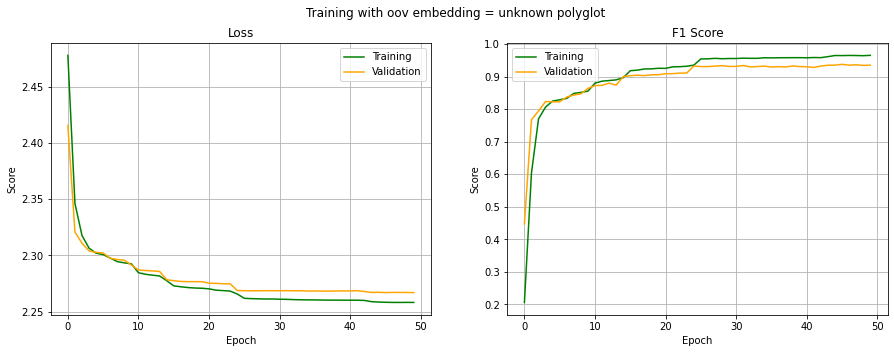

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../logs/unk/fold_{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with oov embedding = unknown polyglot")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9654, device='cuda:0'),
 tensor(0.9368, device='cuda:0'),
 tensor(0.9354, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9654, device='cuda:0'),
 tensor(0.9368, device='cuda:0'),
 tensor(0.9354, device='cuda:0'))

## Heatmap

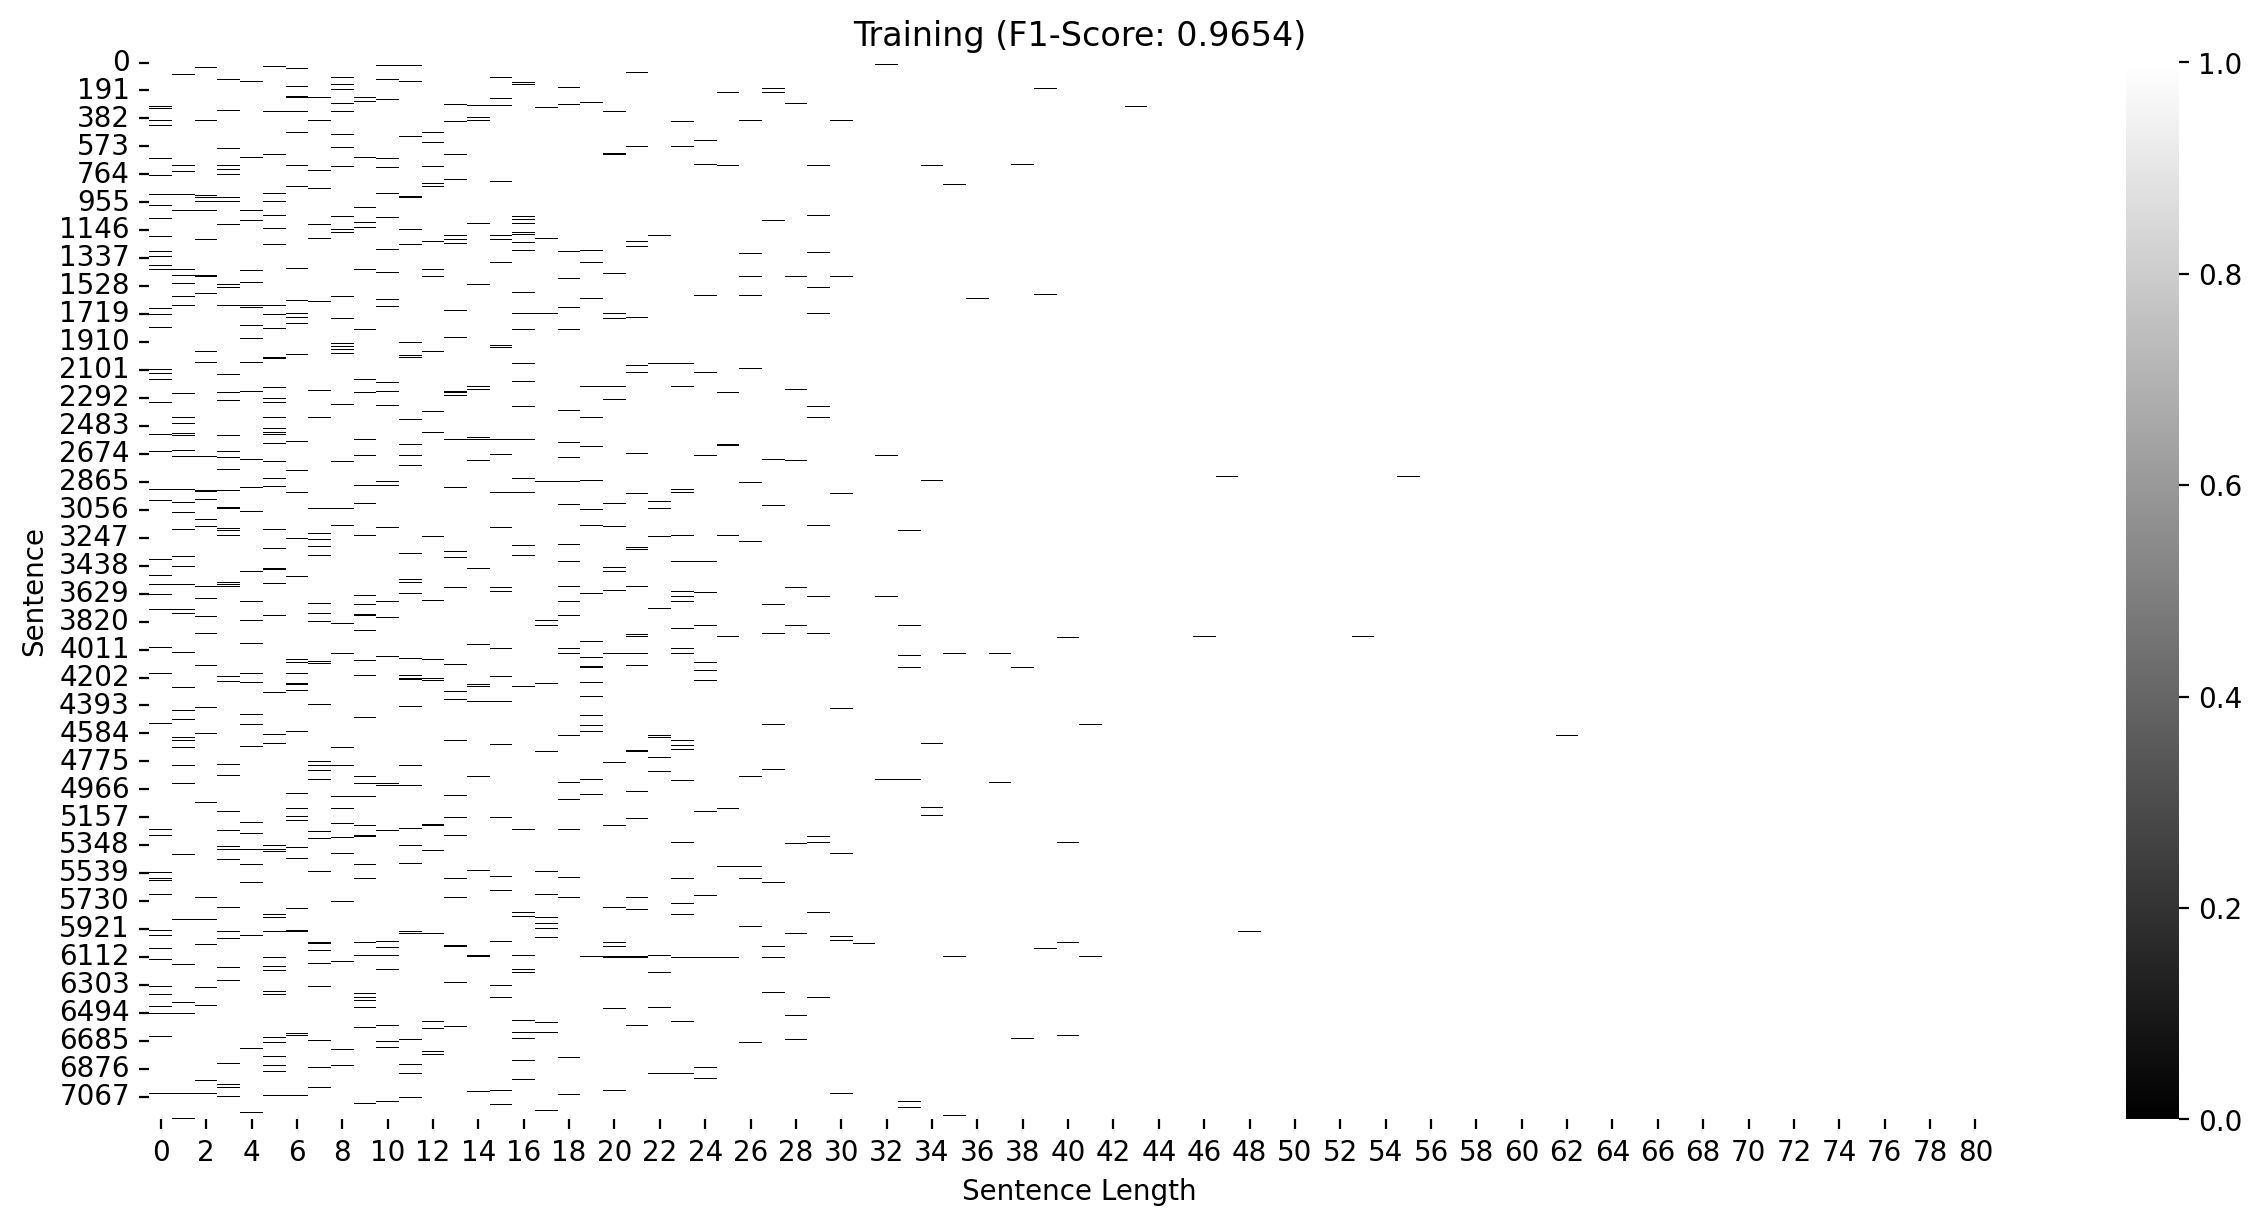

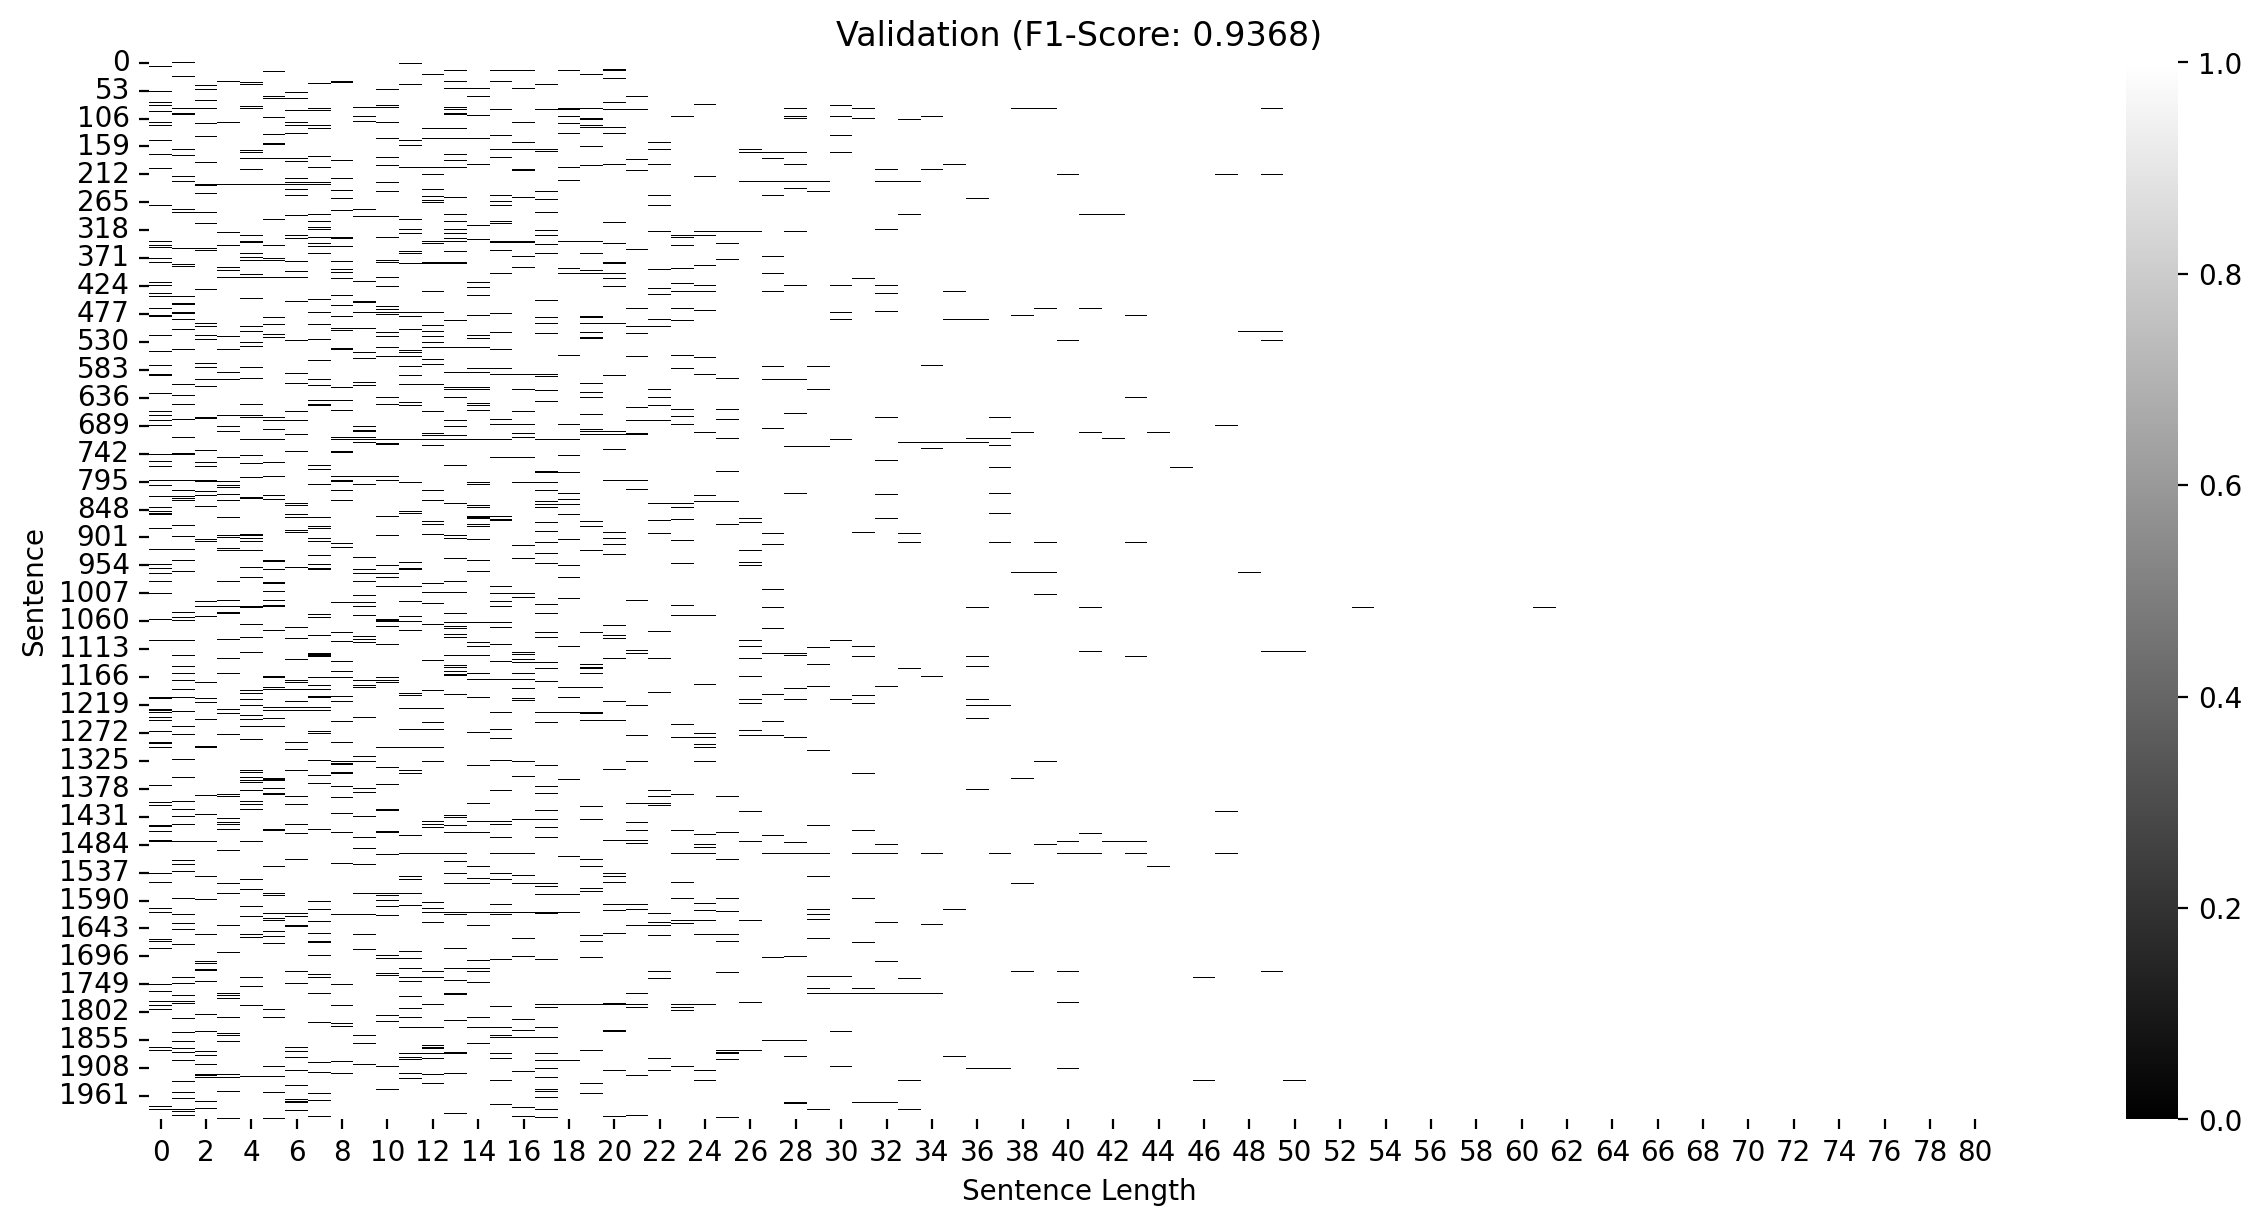

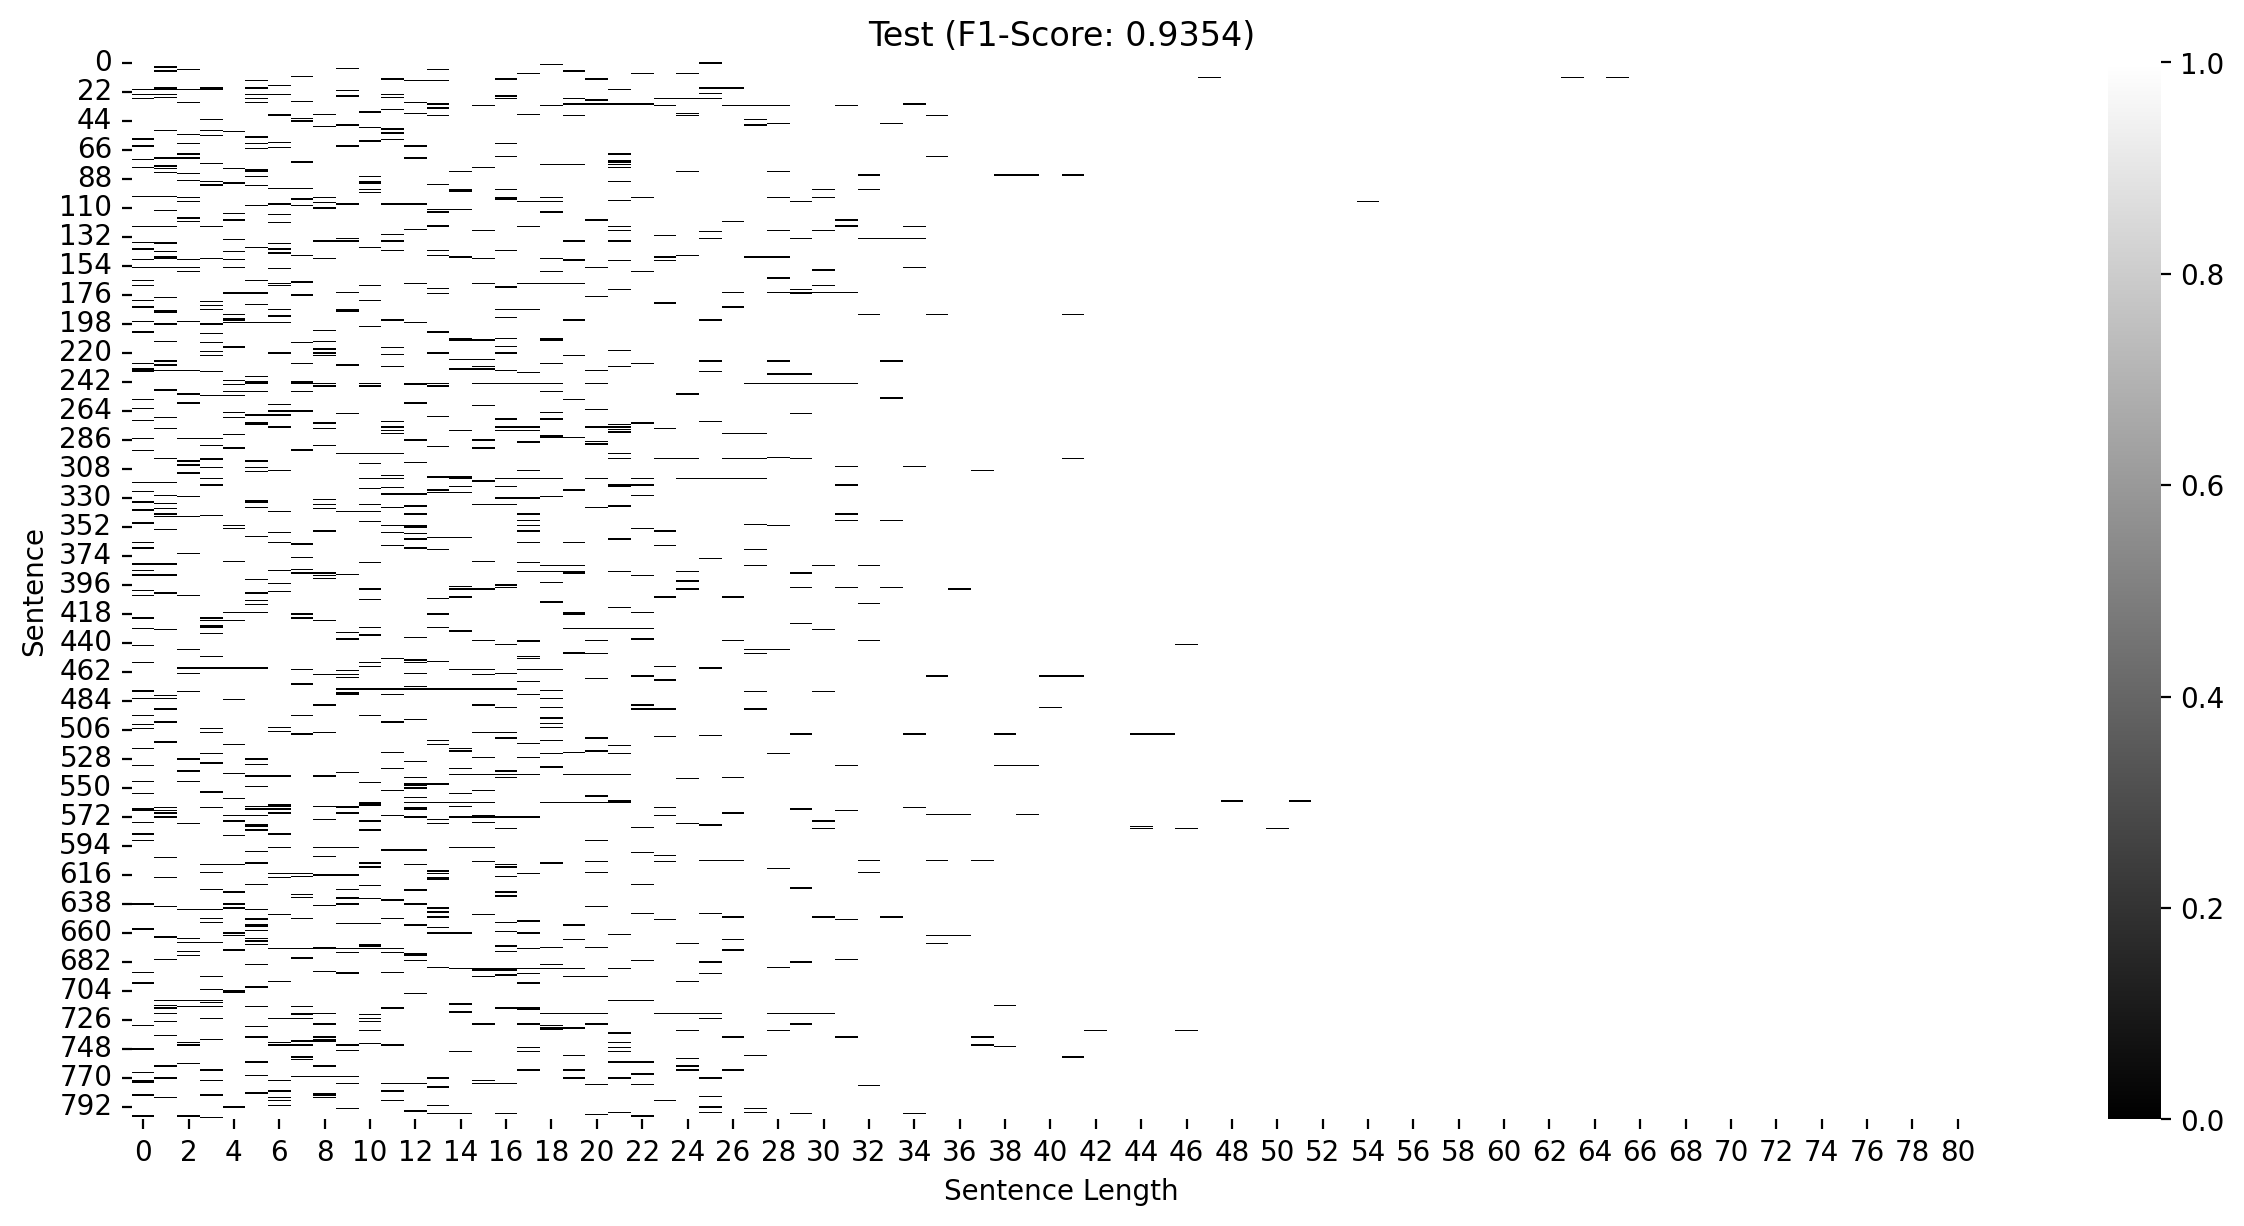

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


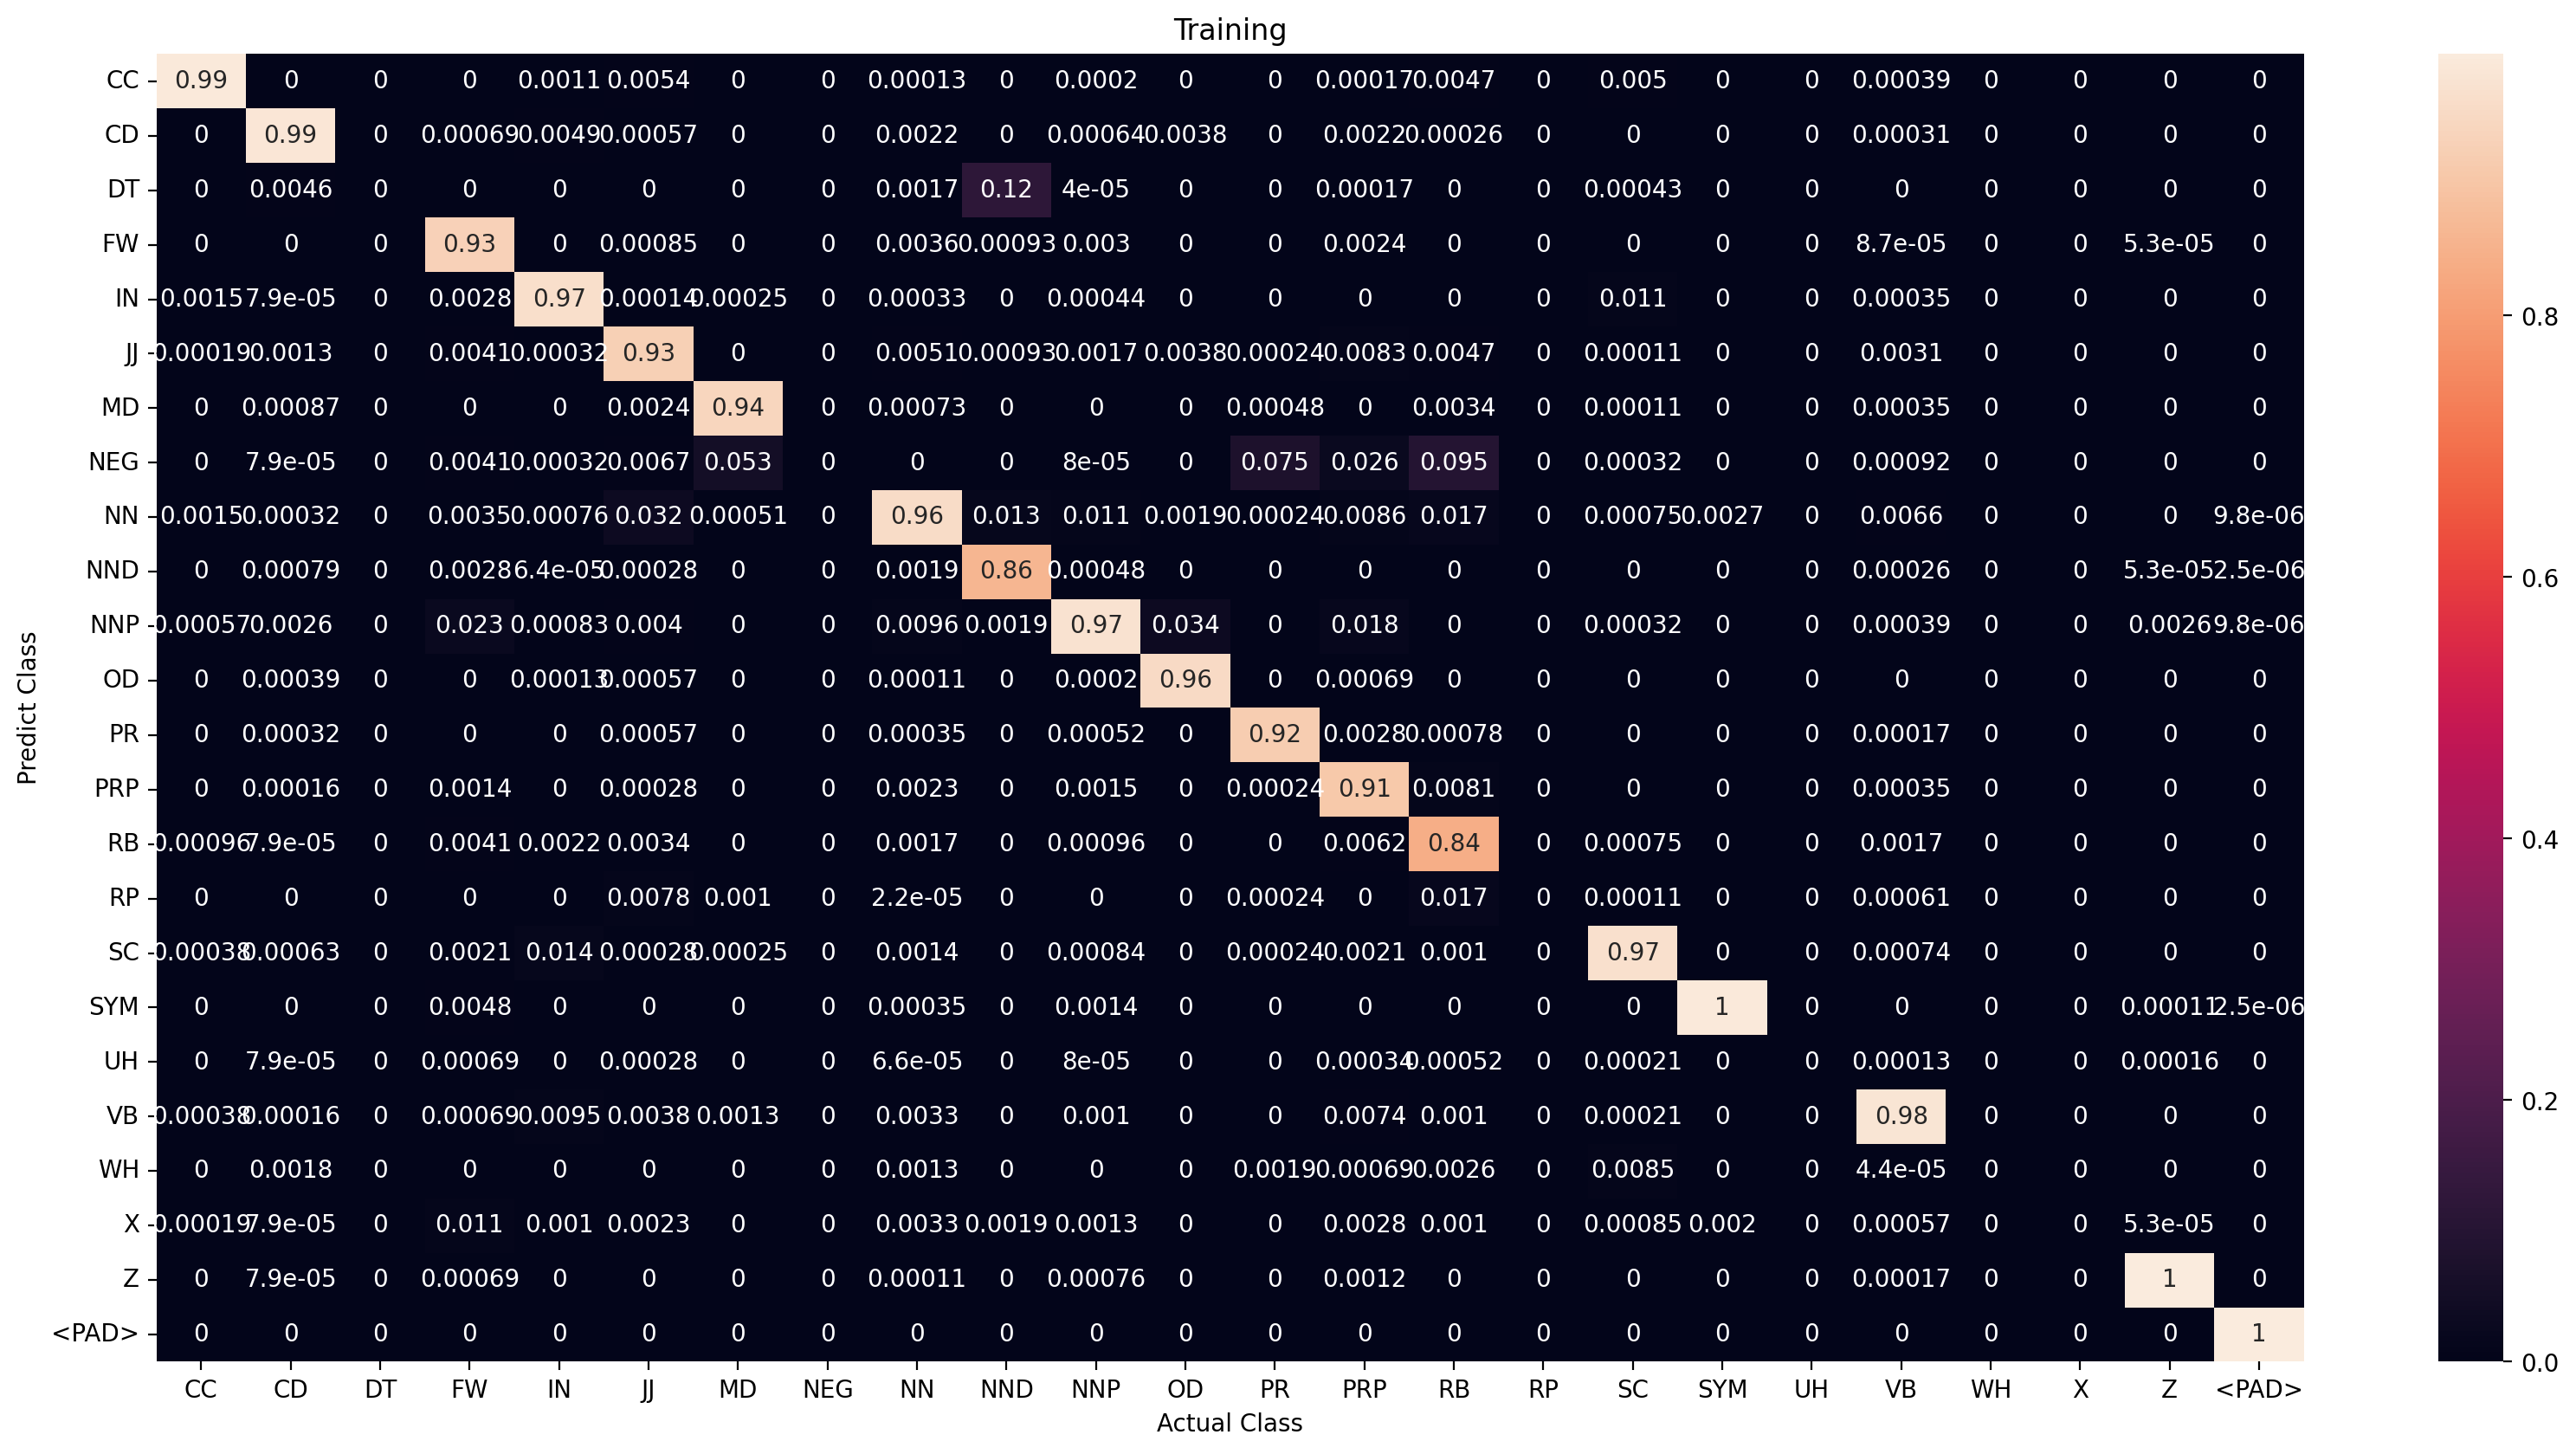

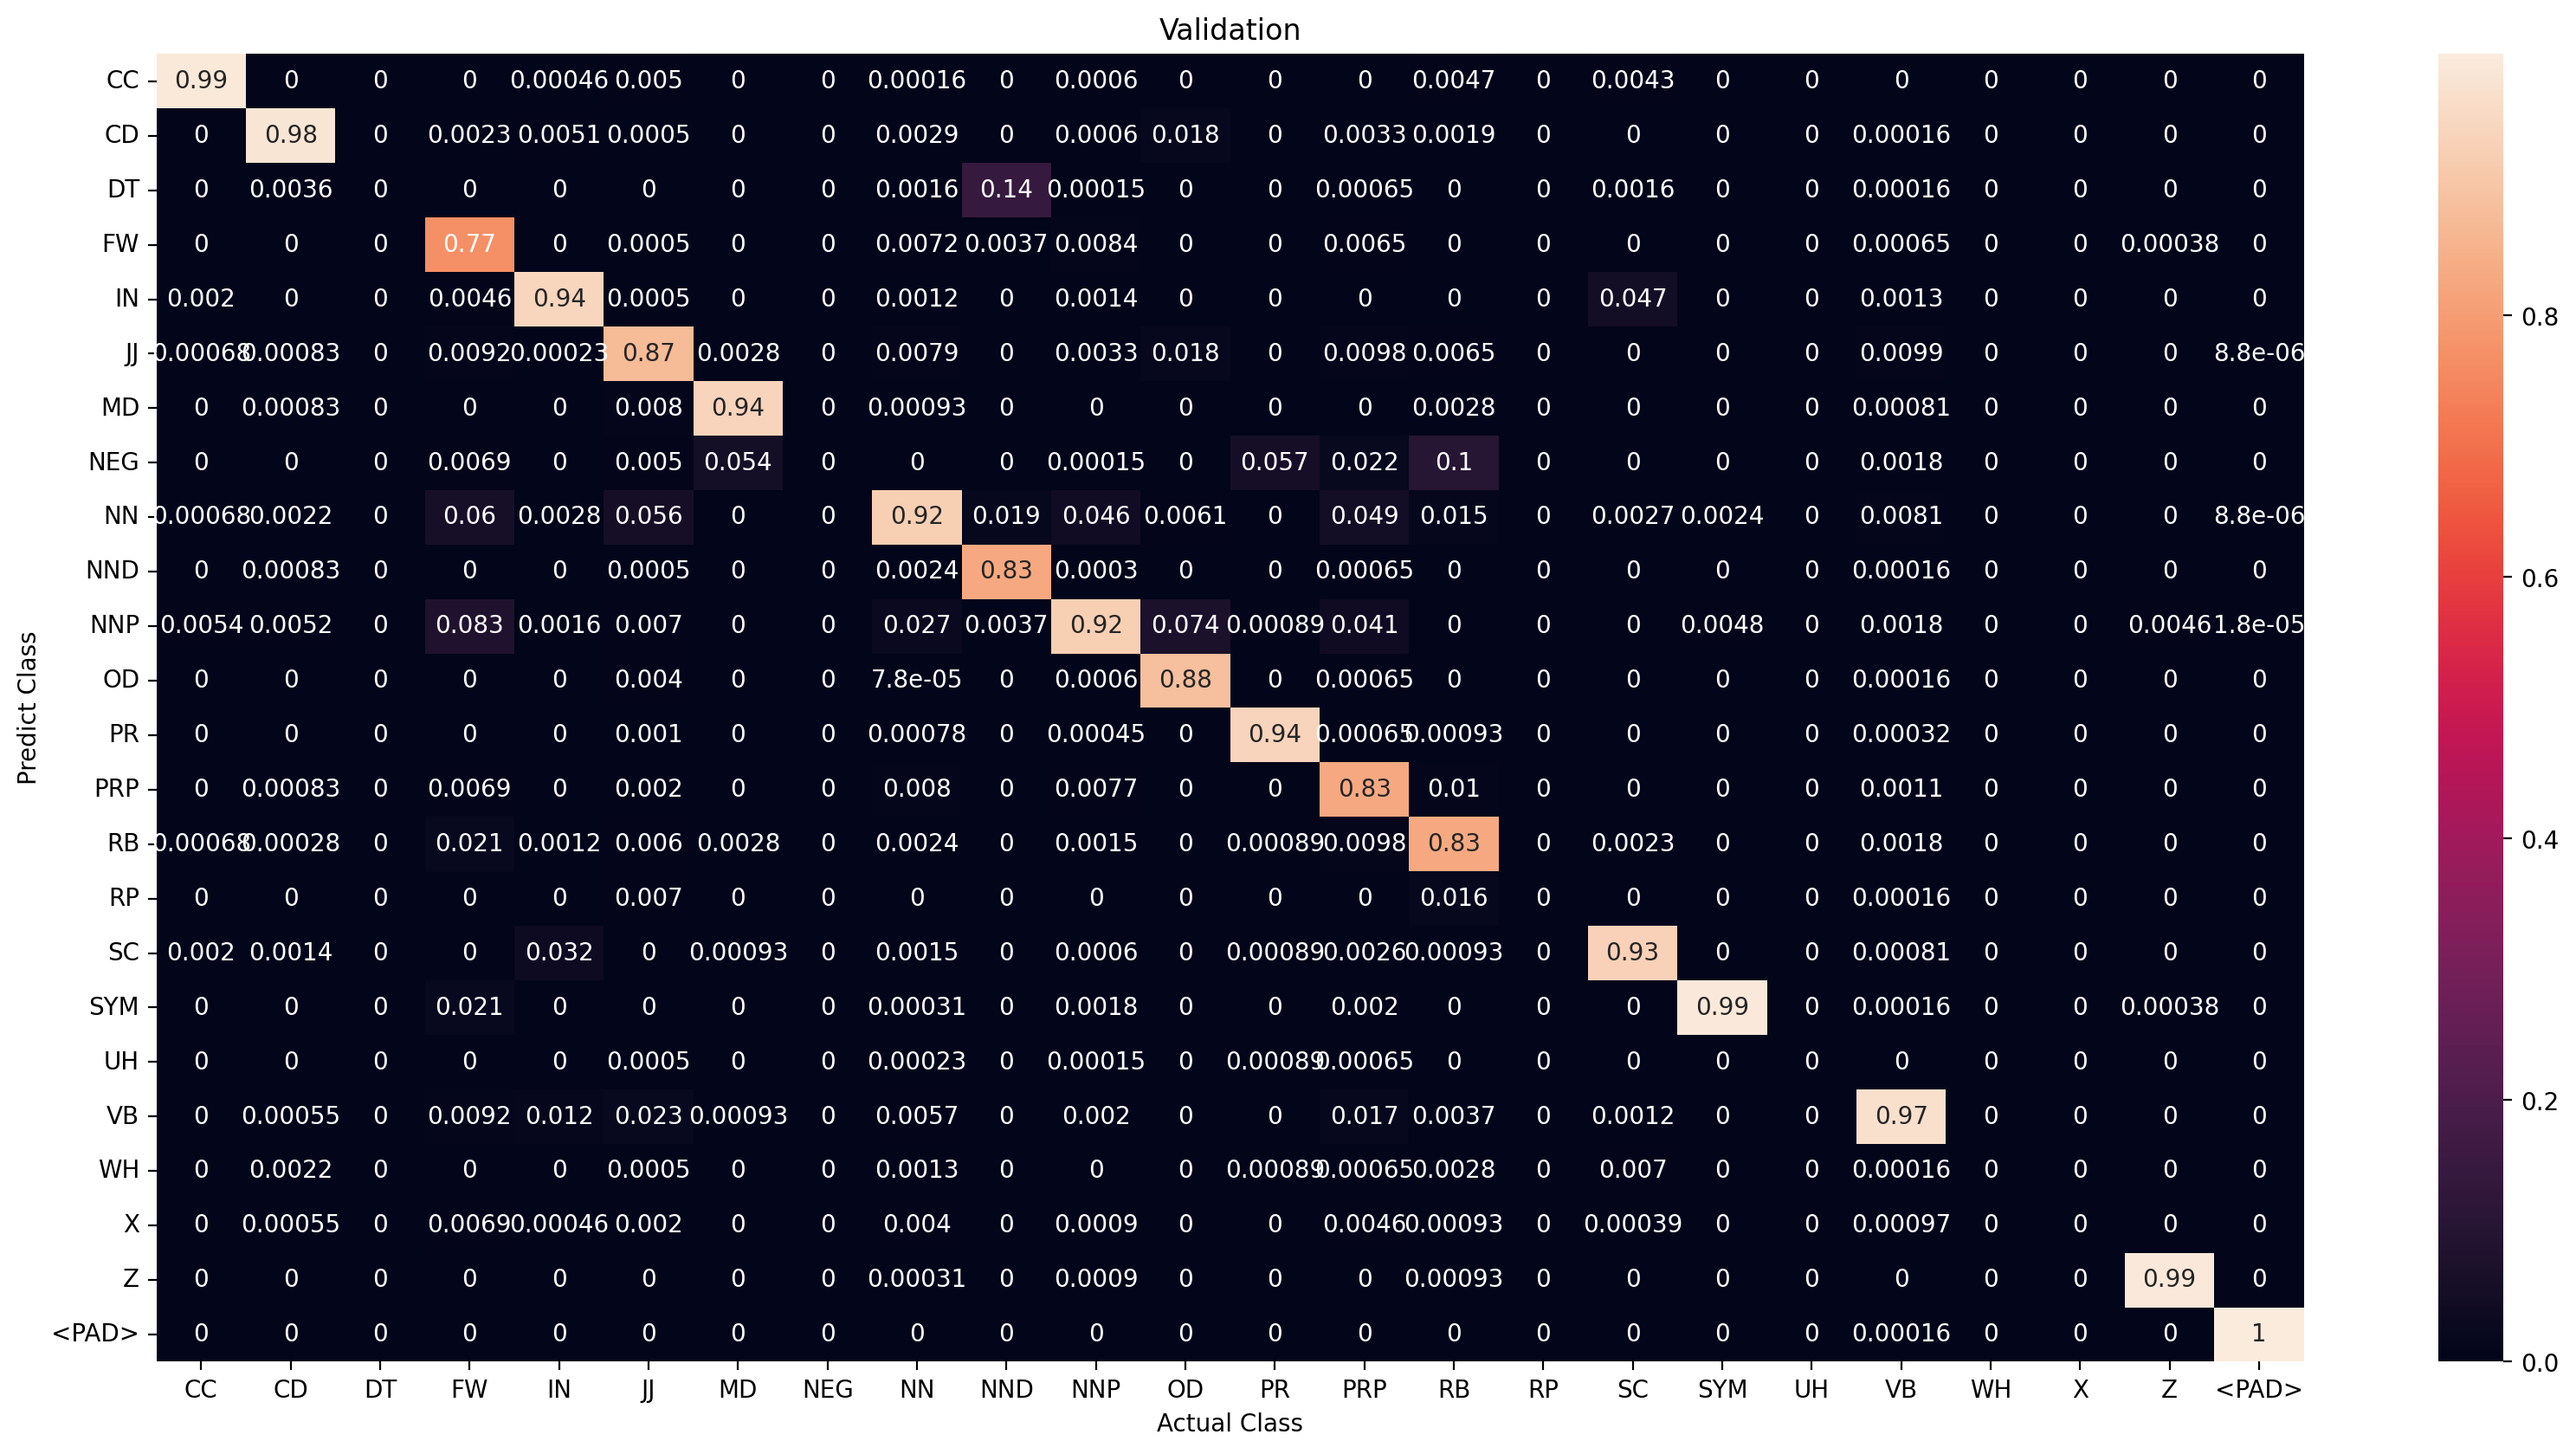

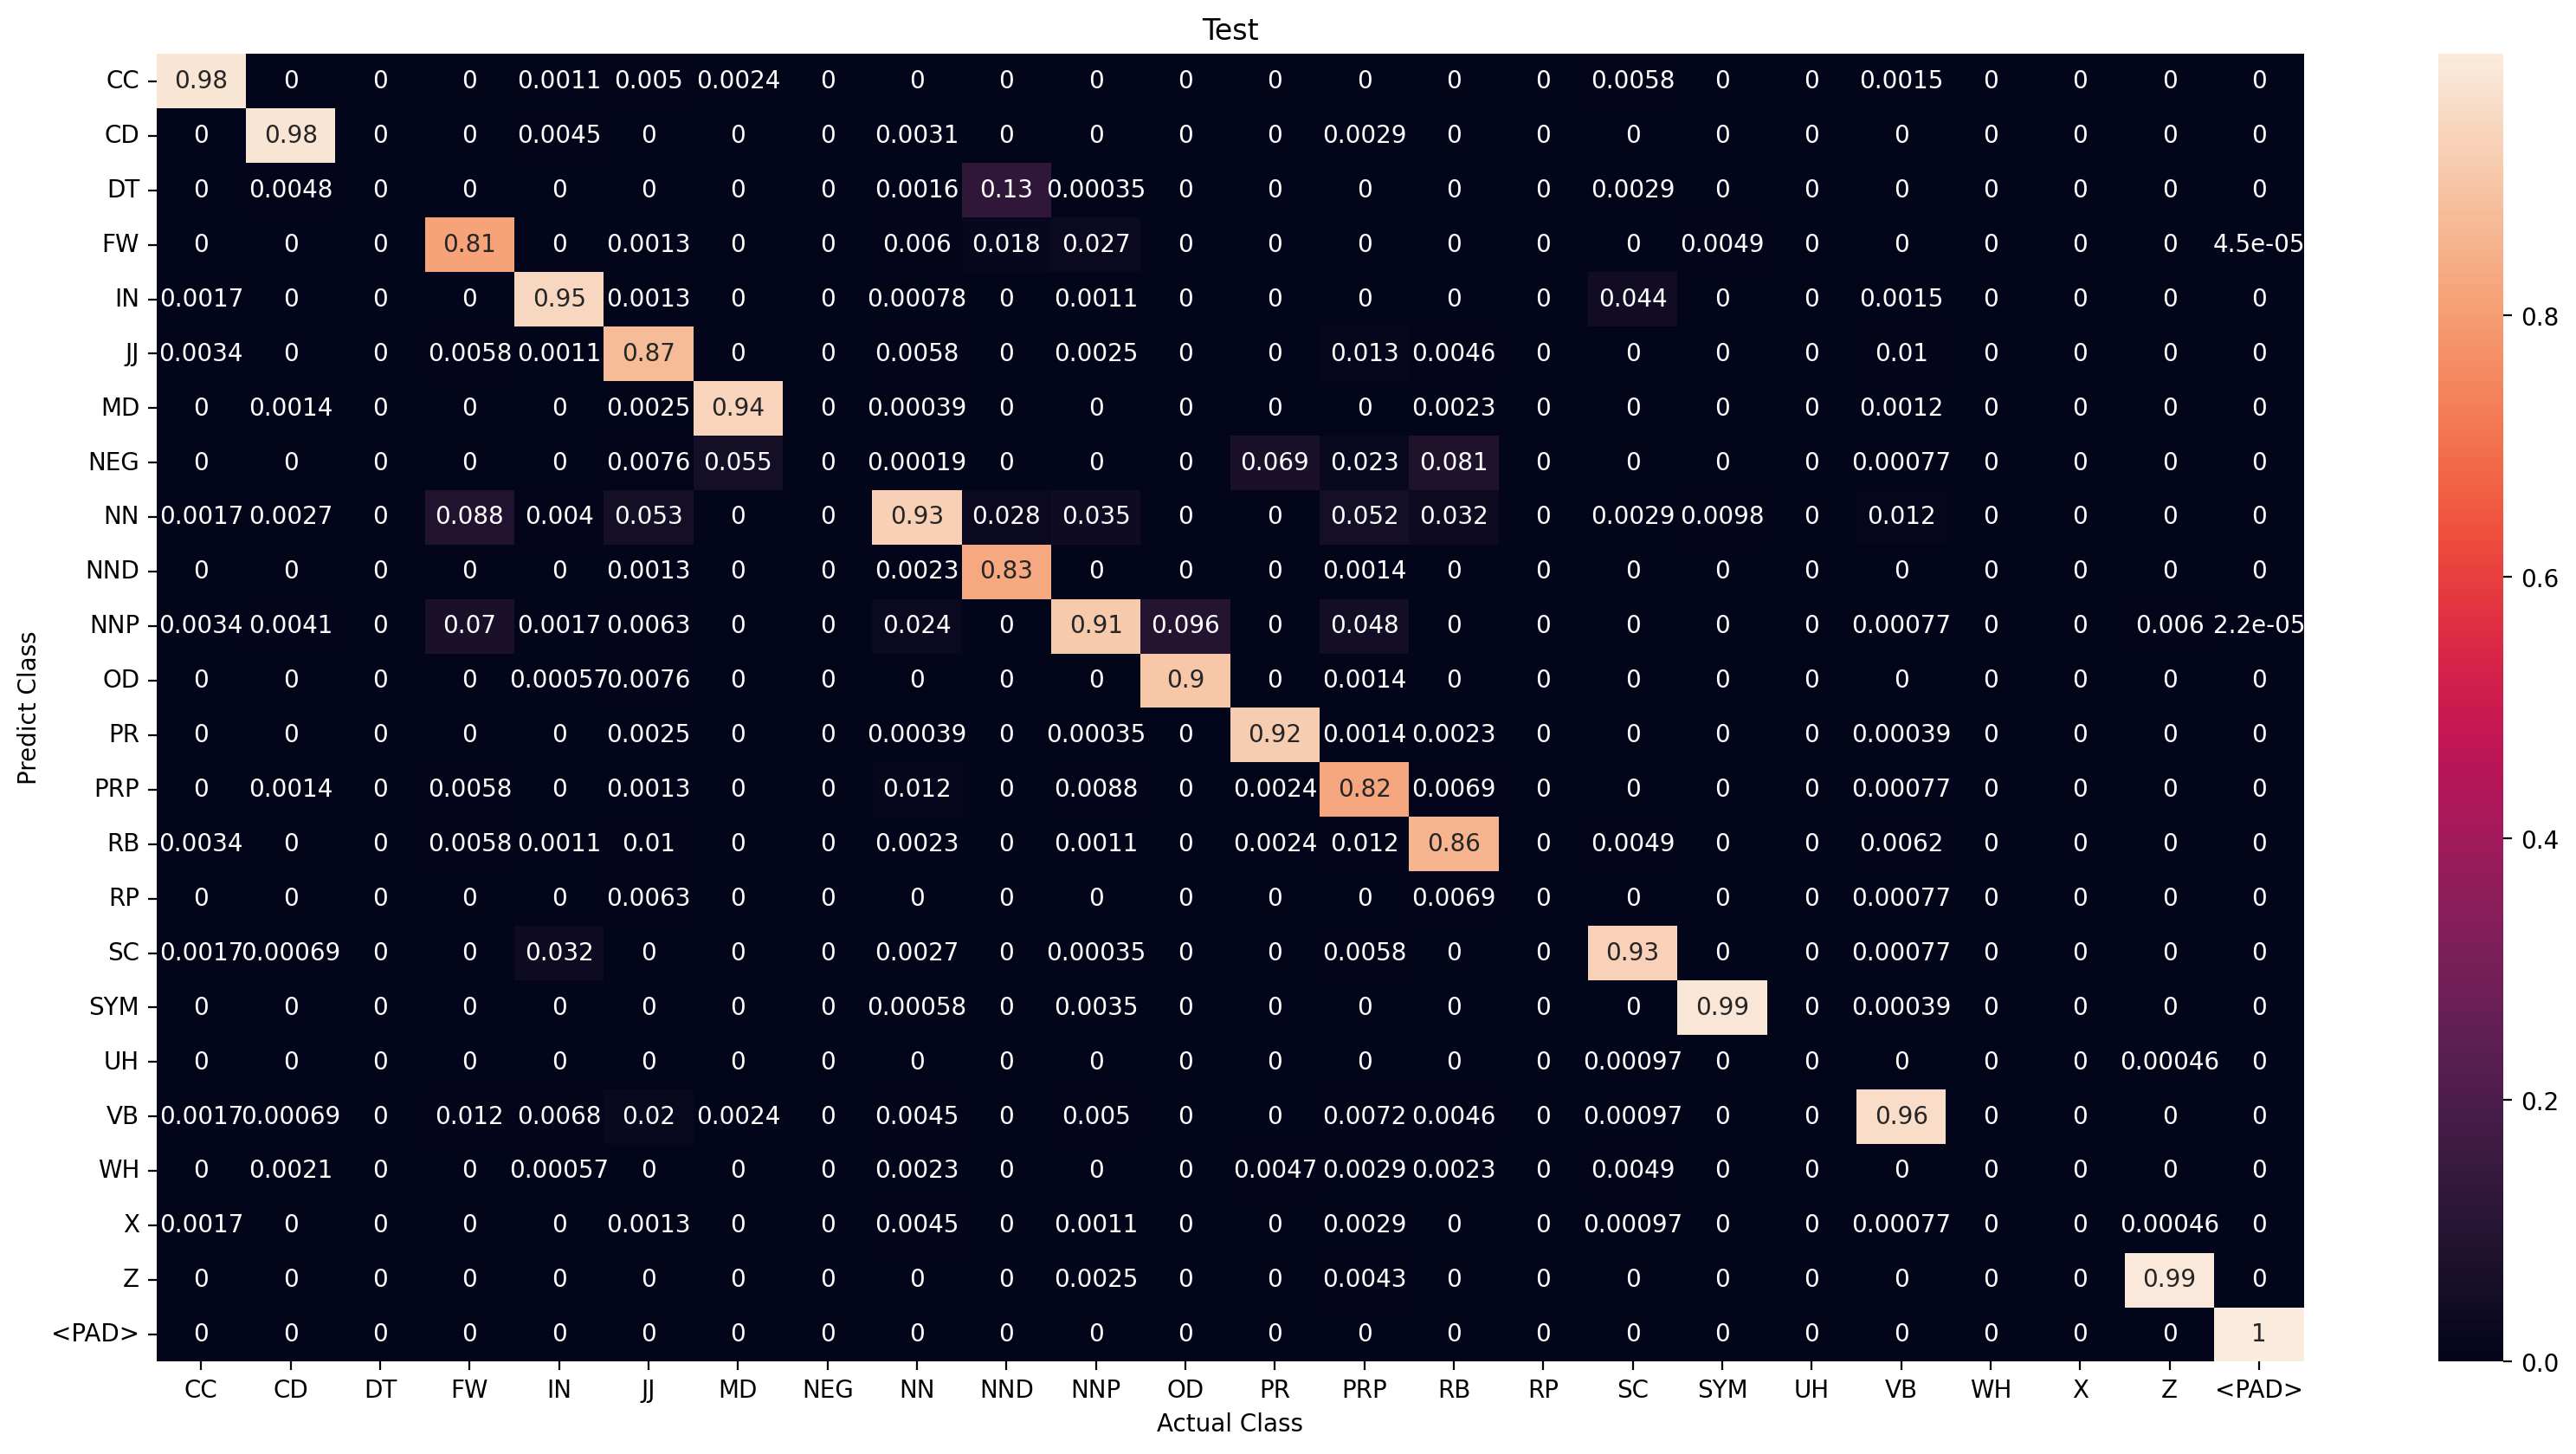

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5346   | CC    : 5205       | CC    : 141      |
| CD    : 12730  | CD    : 12510      | CD    : 220      |
| DT    : 269    | DT    : 0          | DT    : 269      |
| FW    : 1614   | FW    : 1352       | FW    : 262      |
| IN    : 15342  | IN    : 15190      | IN    : 152      |
| JJ    : 6981   | JJ    : 6535       | JJ    : 446      |
| MD    : 3799   | MD    : 3714       | MD    : 85       |
| NEG   : 1118   | NEG   : 0          | NEG   : 1118     |
| NN    : 44369  | NN    : 43542      | NN    : 827      |
| NND   : 1047   | NND   : 925        | NND   : 122      |
| NNP   : 25175  | NNP   : 24438      | NNP   : 737      |
| OD    : 524    | OD    : 499        | OD    : 25       |
| PR    : 3880   | PR    : 3820       | PR    : 60       |
| PRP   : 5471   | PRP   : 5284       | PRP   : 187      |
| RB    : 3477   | RB    : 3225       | RB    : 252      |
| RP    : 141    | RP    : 0          | RP    : 141     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  8, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11806
Correct prediction          : 10249
Wrong prediction            : 1557
Percentage correct oov pred : 86.81179061494156

Validation
Number OOV token            : 3366
Correct prediction          : 2397
Wrong prediction            : 969
Percentage correct oov pred : 71.21212121212122

Test
Number OOV token            : 1390
Correct prediction          : 975
Wrong prediction            : 415
Percentage correct oov pred : 70.14388489208633



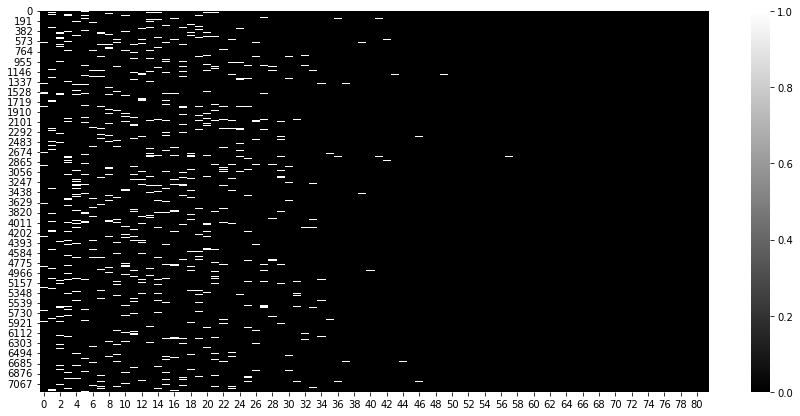

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

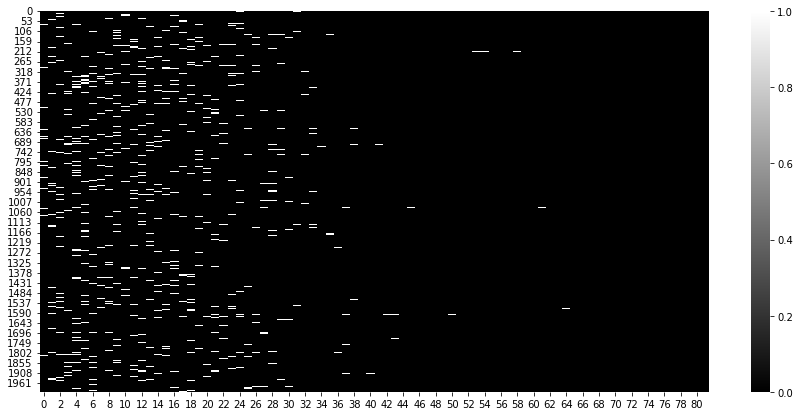

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

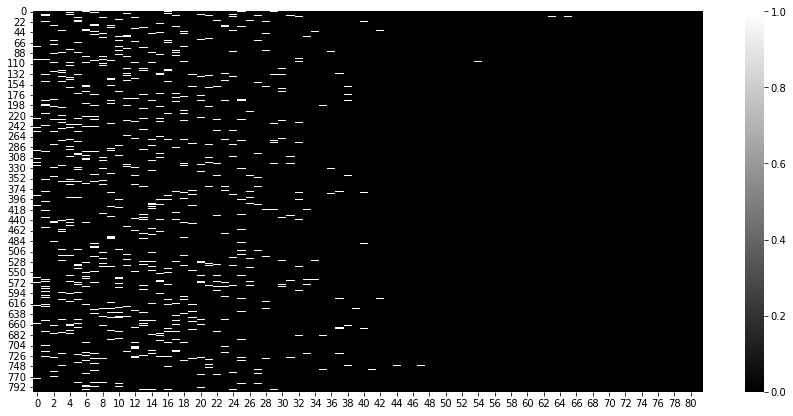

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);